In [13]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
print(tf.__version__)

2.15.0


In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[]

# Remove dodgy images

In [6]:
import cv2
import imghdr

In [13]:
data_dir = 'train' 

In [14]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [15]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# Load Data

In [53]:
data = tf.keras.utils.image_dataset_from_directory('train')

Found 5232 files belonging to 2 classes.


In [66]:
print("Class Names:", data.class_names)

Class Names: ['NORMAL', 'PNEUMONIA']


In [18]:
data_iterator = data.as_numpy_iterator()

In [60]:
data_iterator

In [64]:
img

In [19]:
batch = data_iterator.next()

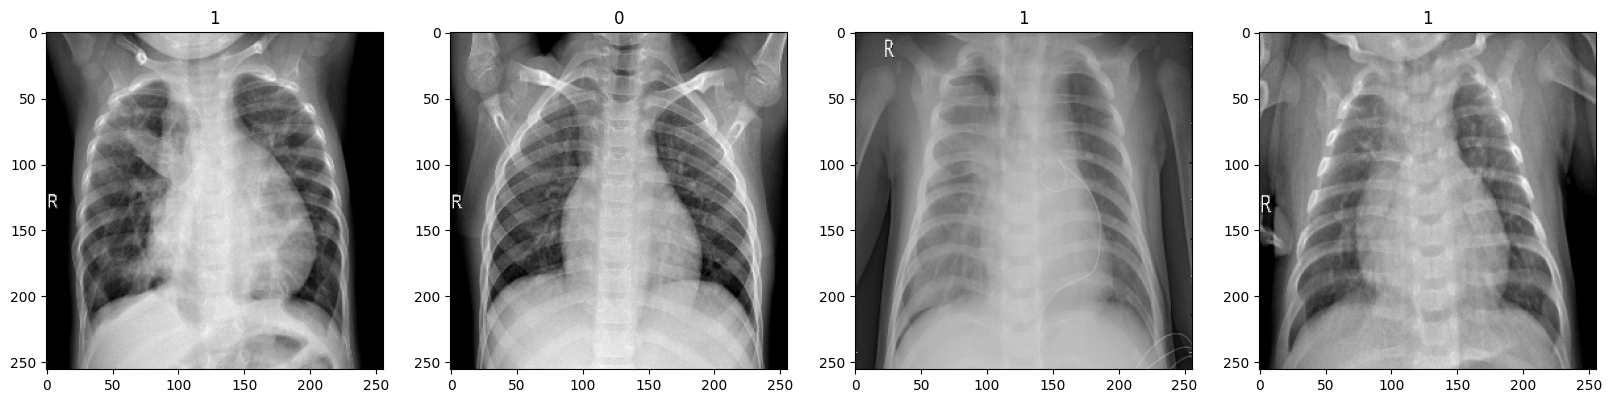

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Scale Data

In [21]:
data = data.map(lambda x,y: (x/255, y))

In [22]:
data.as_numpy_iterator().next()

(array([[[[0.10196079, 0.10196079, 0.10196079],
          [0.10196079, 0.10196079, 0.10196079],
          [0.10196079, 0.10196079, 0.10196079],
          ...,
          [0.8392157 , 0.8392157 , 0.8392157 ],
          [0.8392157 , 0.8392157 , 0.8392157 ],
          [0.84313726, 0.84313726, 0.84313726]],
 
         [[0.10196079, 0.10196079, 0.10196079],
          [0.10196079, 0.10196079, 0.10196079],
          [0.10196079, 0.10196079, 0.10196079],
          ...,
          [0.8392157 , 0.8392157 , 0.8392157 ],
          [0.8392157 , 0.8392157 , 0.8392157 ],
          [0.84313726, 0.84313726, 0.84313726]],
 
         [[0.10196079, 0.10196079, 0.10196079],
          [0.10196079, 0.10196079, 0.10196079],
          [0.10196079, 0.10196079, 0.10196079],
          ...,
          [0.8392157 , 0.8392157 , 0.8392157 ],
          [0.8392157 , 0.8392157 , 0.8392157 ],
          [0.84313726, 0.84313726, 0.84313726]],
 
         ...,
 
         [[0.11764706, 0.11764706, 0.11764706],
          [0.11764

# Split Data

In [23]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [24]:
train_size

114

In [25]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Build Deep Learning Model

In [26]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [28]:
model = Sequential()

In [29]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [30]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# Train 

In [94]:
logdir='logs'

In [95]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [34]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


114/114 [==============================] - 76s 644ms/step - loss: 0.3217 - accuracy: 0.8649 - val_loss: 0.3136 - val_accuracy: 0.8652
Epoch 2/20
114/114 [==============================] - 76s 658ms/step - loss: 0.1236 - accuracy: 0.9564 - val_loss: 0.0963 - val_accuracy: 0.9697
Epoch 3/20
114/114 [==============================] - 75s 650ms/step - loss: 0.0769 - accuracy: 0.9742 - val_loss: 0.1362 - val_accuracy: 0.9521
Epoch 4/20
114/114 [==============================] - 73s 632ms/step - loss: 0.0609 - accuracy: 0.9786 - val_loss: 0.0630 - val_accuracy: 0.9785
Epoch 5/20
114/114 [==============================] - 73s 630ms/step - loss: 0.0465 - accuracy: 0.9814 - val_loss: 0.1574 - val_accuracy: 0.9492
Epoch 6/20
114/114 [==============================] - 85s 737ms/step - loss: 0.0549 - accuracy: 0.9800 - val_loss: 0.0976 - val_accuracy: 0.9746
Epoch 7/20
114/114 [==============================] - 71s 615ms/step - loss: 0.0393 - accuracy: 0.9830 - val_loss: 0.1114 - val_

# Plot Performance

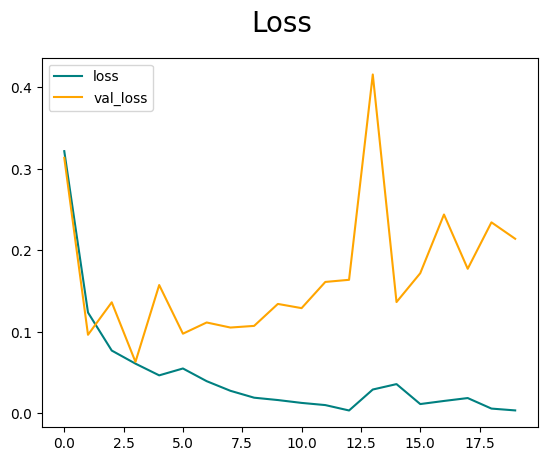

In [35]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

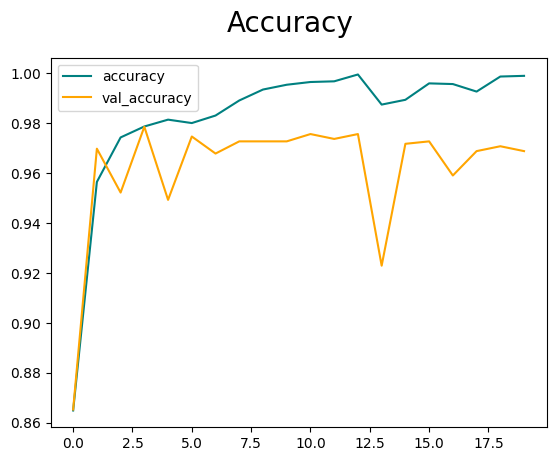

In [36]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate

In [37]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [38]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [39]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 110ms/step


In [40]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.9587629, shape=(), dtype=float32) tf.Tensor(0.98673743, shape=(), dtype=float32) tf.Tensor(0.9589844, shape=(), dtype=float32)


# Test

In [96]:
import cv2

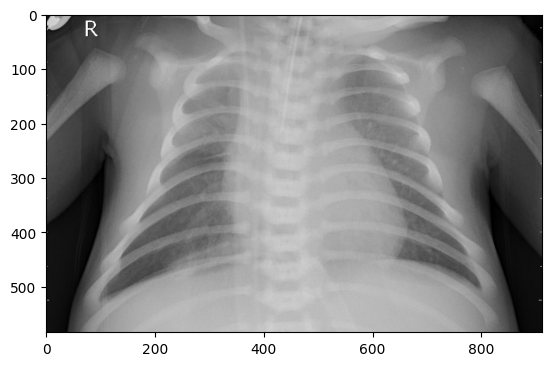

In [100]:
img = cv2.imread('BACTERIA-227418-0001.jpeg')
plt.imshow(img)
plt.show()

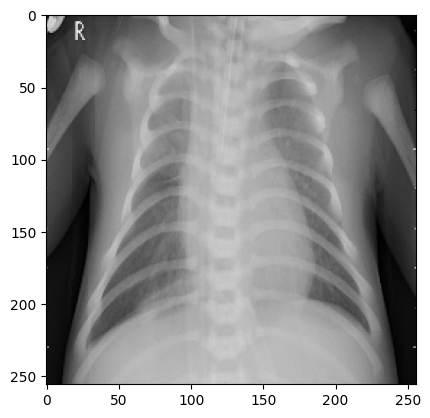

In [101]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [102]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 39ms/step


In [103]:
yhat

array([[0.9999994]], dtype=float32)

In [104]:
if yhat > 0.5: 
    print(f'Predicted class is PNEUMONIA')
else:
    print(f'Predicted class is Normal')

Predicted class is PNEUMONIA


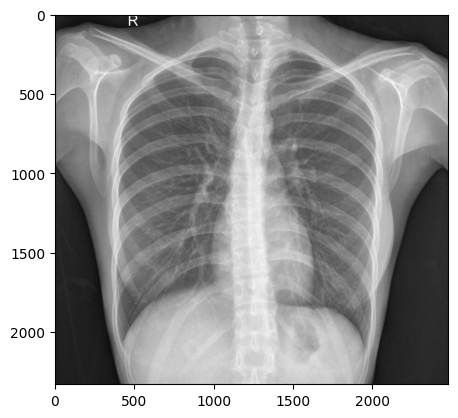

In [109]:
img = cv2.imread('NORMAL-3782395-0001.jpeg')
plt.imshow(img)
plt.show()

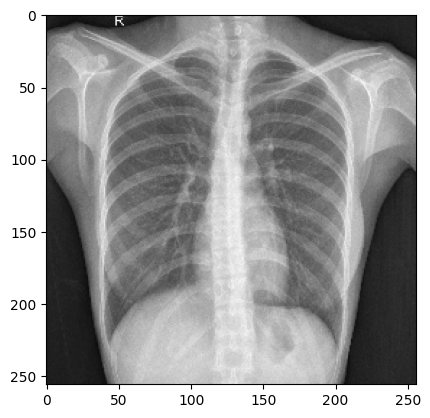

In [110]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [111]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 39ms/step


In [112]:
yhat

array([[0.3160937]], dtype=float32)

In [114]:
if yhat > 0.5: 
    print(f'Predicted class is PNEUMONIA')
else:
    print(f'Predicted class is Normal')

Predicted class is Normal


# Save the Model

In [17]:
from tensorflow.keras.models import load_model

In [18]:
model.save(os.path.join('models','covid_detection.h5'))

NameError: name 'model' is not defined

# Load Saved Model

In [23]:
new_model = load_model('saved_model_covid_detection.h5')

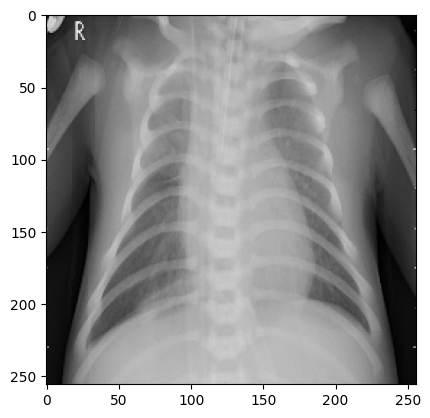

In [24]:
img = cv2.imread('BACTERIA-227418-0001.jpeg')
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [25]:
yhat = new_model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 94ms/step


array([[0.9999994]], dtype=float32)

In [26]:
if yhat > 0.5: 
    print(f'Predicted class is PNEUMONIA')
else:
    print(f'Predicted class is Normal')

Predicted class is PNEUMONIA
